In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import itertools 
import matplotlib as mpl
import matplotlib.pyplot as plt

rc={'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally

rc={'font.size': 8} #, 'axes.labelsize': 10, 'legend.fontsize': 10.0, 
  #  'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)

plt_params = {'mathtext.default': 'regular' }  

plt_params.update(rc)

plt.rcParams.update(plt_params)


import torch
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification
import tqdm as tqdm
import os
import torch
import pickle
import pandas as pd
import inspect
from transformers import (
    DataCollatorWithPadding,
    Trainer,EvalPrediction,InputFeatures)

from utils import set_up_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#  './*/all_flips_{}.p' is the output of {SST/IMDB}/run_{SST/IMDB}.py


# SST
data_sst = {}
dataset_name = 'sst'
for flip_case in ['generate', 'pruning']:

    root_dir = 'all_flips_{}_{}.p'
    root_dir_flow = 'all_flips_{}_{}.p'

    pfile = root_dir.format(flip_case, dataset_name) 

    res_ =  pickle.load(open(pfile, 'rb'))
        
    data_sst[flip_case] = res_

data_sets = {'sst':data_sst}
        

872
872
872
872
872
872
872
872
872
872
872
872
872
872
872
872
872
872


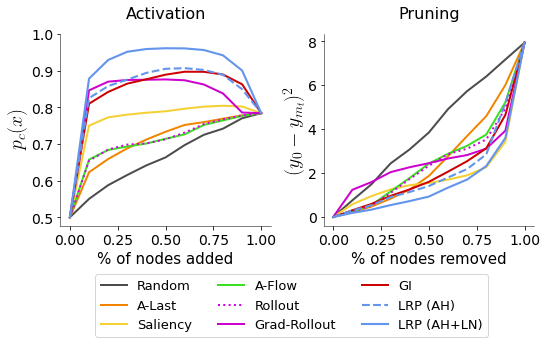

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


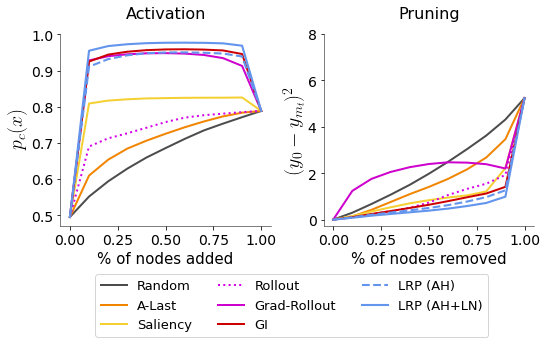

In [70]:
from matplotlib import pyplot as plt
from plot_utils import plot_flips


params = {
    'gi': ('#cc0000','-','GI'),
    'lrp_detach_KQ_LNorm_Norm': ('#6495ED','-',r'LRP (AH+LN)'),    
    'lrp_detach_KQ': ('#6495ED','--',r'LRP (AH)'),
    'rollout_2': ('#d400e7','dotted','Rollout'),
    'GAE': ('#cd00cd','solid','Grad-Rollout'),
    'attn_last': ('#F28500','solid','A-Last'),
    'random': ('#4c4c4c','solid','Random')}
        
    
    
    
    
flip_order = ['random',  
              'attn_last', 
              'rollout_2', 
               'GAE',
               'gi', 
              'lrp_detach_KQ',
              'lrp_detach_KQ_LNorm_Norm',
              ]

save_dir = 'experiments/2502021_evaluation_revised' 


set_up_dir(save_dir)
imfile = os.path.join(save_dir,'sst_overview.pdf')
plot_flips(data_sets['sst'], flip_order=flip_order,params=params,  imfile=imfile)



flip_order = ['random',  
              'attn_last', 
              'saliency', 
              'rollout_2', 
              'chefer',
               'gi', 
              'lrp_detach_KQ',
              'lrp_detach_KQ_LNorm_Norm',
              ]

imfile = os.path.join(save_dir,'imdb_overview.pdf')
plot_flips(data_sets['imdb'], flip_order, params, imfile=imfile)

In [71]:
# def make table
from scipy.integrate import trapz, simps

table_order = ['random',  
              'attn_last', 
              'saliency', 
              'attention_flow_2', 
              'rollout_2', 
              'gi',
              'chefer',  
              'lrp_detach_KQ',
              'lrp_detach_KQ_LNorm_Norm',
              ]


metrics = [('generate', 'E'), ('pruning', 'E'), ('pruning', 'M')]

metric_map = {'generate_E': 'AUAC', 'pruning_E': 'AUPC', 'pruning_M':'AU-MSE'}
method_map = {}
for k,v in params.items():
    method_map[k] = v[2]
    

fracs = np.linspace(0.,1.,11)

dataname_map = {'sst': 'SST-2', 'imdb':'IMDB'}

df_all = {}
for flip_case, metric in metrics:
    
    data_table = []

    for dataset in ['imdb', 'sst']:
    
        data_ = data_sets[dataset]
    
        flip_data = data_[flip_case]
        data_col = [] #['names']+ [dataset]]

        for i,k in enumerate(table_order):

            if k not in flip_data:
                f = '-'
            else:
                v = flip_data[k]
                f_ = np.nanmean(v[metric], axis=0)
                f = trapz(f_, fracs)
                f = '{:0.3f}'.format(f)

                
            data_col.append(f)
        data_table.append(['\rotatebox{90}{'+dataname_map[dataset]+'}'] + data_col)


    df_metric = pd.DataFrame(np.array(data_table), columns =['names'] + [method_map[k_] for k_ in table_order])
    metric_name= metric_map[flip_case + '_' + metric]
    
    
    df_metric = df_metric.set_index('names')
    
    df_metric
    df_all[metric_name] = df_metric

In [72]:
def _recover_control_sequences(s: str) -> str:
    s = s.replace(r"\}", "}")
    s = s.replace(r"\{", "{")
    s = s.replace(r"textbackslash ", "")
    return s

str_ = df_all['AUAC'].T.to_latex(index=True)
print(_recover_control_sequences(str_))



str_ = df_all['AUPC'].T.to_latex(index=True)
print(_recover_control_sequences(str_))



str_ = df_all['AU-MSE'].T.to_latex(index=True)
print(_recover_control_sequences(str_))

\begin{tabular}{lll}
\toprule
names & \rotatebox{90}{IMDB} & \rotatebox{90}{SST-2} \\
\midrule
Random       &                0.673 &                 0.664 \\
A-Last       &                0.708 &                 0.712 \\
Saliency     &                0.804 &                 0.773 \\
A-Flow       &                    - &                 0.711 \\
Rollout      &                0.738 &                 0.713 \\
GI           &                0.920 &                 0.847 \\
Grad-Rollout &                0.909 &                 0.834 \\
LRP (AH)     &                0.911 &                 0.855 \\
LRP (AH+LN)  &                0.939 &                 0.908 \\
\bottomrule
\end{tabular}

\begin{tabular}{lll}
\toprule
names & \rotatebox{90}{IMDB} & \rotatebox{90}{SST-2} \\
\midrule
Random       &                0.667 &                 0.656 \\
A-Last       &                0.698 &                 0.702 \\
Saliency     &                0.732 &                 0.718 \\
A-Flow       &             

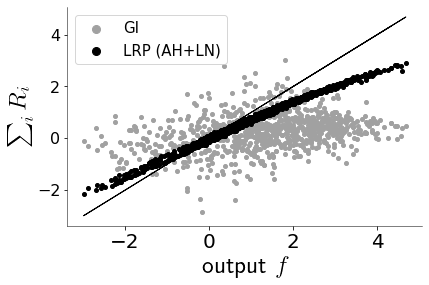

In [77]:
from plot_utils import plot_conservation

res = pickle.load(open('/home/oeberle/explainable_embeds/XNLP/experiments/26012022_sst_conservation/conservation.p', 'rb'))

savefile = 'experiments/conservation_sst.pdf'

plot_conservation(res, savefile)


In [5]:
res.keys()

dict_keys(['gi', 'gi_detach_KQ_LNorm_Norm'])